# Dimension Reduction via Sinusoidal Projection

### EECS 16B: Designing Information Devices and Systems II

# Motivation

In this python exercise we will demonstrate how projections can be beneficial in classification. We will use the simple model where we have noisy observations from (known) sinusoidal signals, and try to classify observations to the true sinusoids. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import scipy.cluster
from mpl_toolkits.mplot3d import Axes3D

## Creating data

In our example, we have known sinusoids of frequency $1,3,5, \ldots$ Hz. In our demo, we will suppose there are three true sinusoids. For each of the frequencies, we observe $1000$ noisy data vectors, each consisting of a set of $32$ sampled points. The observations are corrupted by noise scaled by $2.0$. You may play around with these values to see what happens.

In [76]:
print('Max amplitude of sine: ', max(np.sin(2 * np.pi * 5 * np.arange(1000) / Fs)))
print('Max amplitude of noise: ', max(np.random.normal(loc=0.0, scale=sigma, size=[sample,])))

Max amplitude of sine:  1.0
Max amplitude of noise:  16.15542792522552


In [16]:
# 1000 sinusoids at once causes error rate to increase by a lot
num_sinusoids = 500 # number of true sinusoids
num_data = 100 # number of data vectors for each sinusoid
Fs = 1000 # sample rate
sample = 1*Fs # number of samples
sigma = 5 # noise scale

def generate_sinusoids(num_sinusoids, num_data, Fs, sample, sigma):
    """
    Generates noisy sinusoidal data for us. Hint: use np.random.normal() function with loc = 0.0 and scale = sigma for noise.
    inputs:
      num_sinusoids: number of true sinusoids
      num_data: number of data vectors for each sinusoid
      Fs: sample rate
      sample: number of samples
      sigma: # noise scale
    returns:
      presorted: a list of num_sinusoids lists, with each sublist having num_data amount of noisy sinusoidal vectors
    """
    presorted = []
    for k in range(num_sinusoids):
        f = 2*k+1 # Frequency of Signal
        data = []
        for i in range(num_data):
            x = np.arange(sample)
            vec = np.sin(2 * np.pi * f * x / Fs) + np.random.normal(loc=0.0, scale=sigma, size=[sample,])
            data.append(vec)
        presorted.append(data)
    return presorted

presorted = generate_sinusoids(num_sinusoids, num_data, Fs, sample, sigma)
sinusoids = np.concatenate([np.array(i) for i in presorted])

We also generate true sinusoid values.

In [17]:
true_list = generate_sinusoids(num_sinusoids, 1, Fs, sample, 0.0)
true_sinusoid = np.concatenate([np.array(i) for i in true_list])
print(len(sinusoids), len(true_sinusoid))

50000 500


## Plotting our observations

Let's visualize the data we generated. In the first plot, we plot a picture of $10$ randomly selected sinusoidal shapes. In the following plots, we plot the noisy waveforms for each of the true sinusoids, and plot the average waveforms.

<Figure size 432x288 with 0 Axes>

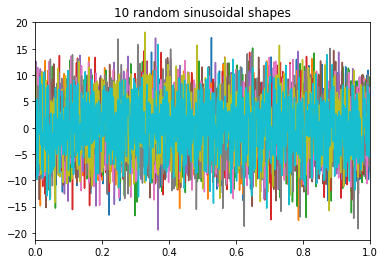

<Figure size 432x288 with 0 Axes>

In [18]:
# randomly choose 10 waveforms to plot
indices = np.random.choice(len(sinusoids), size = 10, replace = False)
x_lims = [i/Fs for i in range(0, sample)]
for waveforms in sinusoids[indices]:
    plt.plot(x_lims, waveforms)
plt.xlim((0,sample/Fs))
plt.title('10 random sinusoidal shapes')
plt.figure()

# plot the 3 sinusoidal shapes based on the presorted data
# for i, waveforms in enumerate(presorted):
#     plt.title('Waveforms of sinusoidal with frequency '+str(2*i+1)+' Hz')
#     for data in waveforms:
#         plt.plot(x_lims, data)
#         plt.xlim((0,sample/Fs))
#     plt.figure()
#     plt.title('Average waveform of sinusoidal with frequency '+str(2*i+1)+' Hz')
#     plt.plot(x_lims, np.mean(waveforms, axis=0))
#     plt.xlim((0,sample/Fs))
#     plt.plot(x_lims, true_sinusoid[i], label = 'True Sinusoid')
#     plt.legend()
#     plt.figure()
    

## Projecting data onto the sinusoidal waves

One way to classify data is to project data onto lower dimensions in hope of having a nice separation in a lower dimension. In this part, we observe what happens when we project the data points onto the linear space spanned by the known sinusoids. 

What does projection mean in this case? In our example, we have $3$ vectors corresponding to the three true frequencies. Let's call them $v_1$, $v_2$ and $v_3$. For some noisy vector $y$, we would want to find the best representation of $y$ in terms of linear combinations of $v_1$, $v_2$ and $v_3$. In other words, we would like to find the coefficients $a_1$, $a_2$ and $a_3$ such that
$$
    y \approx a_1v_1 + a_2v_2 + a_3v_3.
$$

The coefficient $a_1$ can be found by finding the inner product of $y$ and $v_1$ and normalizing:
$$
    a_1 = \frac{\langle y, v_1\rangle}{\langle v_1, v_1\rangle}.
$$
Similarly, we can find $a_2$ and $a_3$ in this fashion.

Next, we define a function to calculate the projections.

In [19]:
def projection(true_sinusoid, sinusoids):
    """
    Projects noisy sinusoids onto the true sinusoids
    inputs:
      true_sinusoid: vectors corresponding to the true_sinusoid
      sinusoids: the noisy observations
    returns:
      presorted_projected: projections of the noisy observations onto the true sinusoids
    """
    # TODO: Your code here
    projs = np.dot(sinusoids, true_sinusoid.T) # Calculate inner product
    projs = projs/np.linalg.norm(true_sinusoid, axis=1, ord=2, keepdims = True).T # Normalize
    return projs

#     presorted_proj = [] 
#     for sin in sinusoids:
#         a_1 = np.inner(sin, true_sinusoid[0]) / np.inner(true_sinusoid[0], true_sinusoid[0])
#         a_2 = np.inner(sin, true_sinusoid[1]) / np.inner(true_sinusoid[1], true_sinusoid[1])
#         a_3 = np.inner(sin, true_sinusoid[2]) / np.inner(true_sinusoid[2], true_sinusoid[2]) 
#         presorted_proj.append(a_1 * true_sinusoid[0] + a_2 * true_sinusoid[1] + a_3 * true_sinusoid[2])
#     return presorted_proj
    
presorted_projected = projection(true_sinusoid, sinusoids)

Let's plot out our projections onto a 3D plot to see how they behave.

In [20]:
def plot_3D(data, view_from_top=False):
    """ 
    Takes list of arrays (x, y, z) coordinate triples and plots 3D map
    input:
      data: num_sinusoids*num_data*num_sinusoids size array of data
      view_from_top: boolean function determining if we plot 3D plot from top
    """
    fig=plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['#0000ff', '#00ff00', '#ff0000']
    for dat, color in zip(data, colors):
        Axes3D.scatter(ax, *dat.T, s=1, c=color, alpha=1.0)
    if view_from_top:
        ax.view_init(elev=90.,azim=0) # Move perspective to view from top

def projection_plot(num_sinusoids, presorted_projected):
    """ 
    Plots 3D projection using data from presorted_projected and the plot_3D function
    input:
      num_sinusoids: number of true frequencies
      presorted_projected: array of projected values
    """
    plot_data = []
    for j in range(num_sinusoids):
        plot_data.append(presorted_projected[j*num_data:(j+1)*num_data])

    plot_3D(np.array(plot_data), False)
    plt.title('Presorted data projected to 3 sinusoidal components')

    plot_3D(np.array(plot_data), True)
    plt.title('Top View: Presorted data projected to 3 sinusoidal components')

#projection_plot(num_sinusoids, presorted_projected)

## Classifying noisy data

From the previous part, we see that after projection, each projected noisy data has one index that is much larger  than the other two indices. We can use this as our classification algorithm. 

In [21]:
def classify(projections):
    """
    Classifies projections based on largest indices; for example, if there are 3 true frequencies, return 0, 1 or 2 if the largest indice is in the 0th, 1st or 2nd position respectively
    input: 
      projections: array of projected values
    returns:
      ind: array of max indices in each row. 
    """
    # Hint: Think about using the function np.argmax
    # TODO: Your code here
    return np.argmax(projections, axis=1)
    

classifications = classify(presorted_projected)

def num_errors(num_sinusoids, classifications):
    """
    Returns number of errors between our classification and the true classes
    input:
      num_sinusoids: number of true frequencies
      classifications: vector of classifications
    output:
      error: number of misclassifications
    """
    # Remember our classification is in terms of indices. To compare this classification with the true frequencies, we create a representation of true class in terms of indices
    true_class = []
    for j in range(num_sinusoids):
        true_class = true_class + [j]*num_data
    ans = sum(i != j for i, j in zip(classifications, true_class))
    return ans

print("Number of errors in classification:", num_errors(num_sinusoids, classifications), "/", num_sinusoids*num_data)    

Number of errors in classification: 4563 / 50000


## Conclusion

Knowing the right dimension to project onto can be useful for many classification tasks. In our setting, we were already given the true sinusoidal values. However, in a practical setting this information is often not readily available to us. In the latter parts of the class we will learn other methods that can help us tackle this issue.

If you played with the noise values, you will also notice that with large enough noise, this method will not work. This is intuitive since we start out with sinusoidal signals with magnitude at most 1. If we add large enough noise, then it will be very hard to distinguish true signal from noise. 